# Business Understanding

The following dataset is a collection of Polish companies in the manifactury sector.

The financial statements have been collected and displayed in the form of CSV format and anonymized. 

In this short version, the analytical approach is to use Ensemble Learning Methods to make inference on the risk of financial distress for the current year.

The metrics used to evaluate the models are:
    
   * F1 Score
   * Accuracy

The evaluation for training will be a randomized-stratified-balanced cross validation optimized for f1 and for different parameter of a Decision Tree model.

The holdout test will be a imbalanced set of companies never seen by the model to asses the robustness of model in a scenario with proportion that are more realistic in terms of prior probability of distress.


# Methodology

* Import Assets
* Custom Pipelines for Data Preparation
* Model Creation
* Model Evaluation 
* Model Deployment


# Custom Models with Jupyter Notebook


Documentation : https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/get-started-wdp.html?audience=wdp

# Notebook Project connection with project_lib



In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='4d5474fe-39ec-4916-a1fc-0de9cde97b42', project_access_token='p-442d4dcac328eedf630f294a1ef4b9dd66cb9235')
pc = project.project_context


# Import Open Source

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats  as stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold , RandomizedSearchCV , train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score ,roc_auc_score,average_precision_score,roc_curve,auc

# Asset from Project to Notebook

In [3]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6835a25231684991b18d2fc9926df7c4 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='CBvxmsVgX-dXnOj6WdVTTpQycj56rqr1HBFR6UV2tsyS',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_6835a25231684991b18d2fc9926df7c4.get_object(Bucket='codemotion2021datascienceperlanal-donotdelete-pr-msbcvswnxw0b8a',Key='Bankrupt_1year.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

    
    



df = pd.read_csv(body,na_values=['?'])
df.head()


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,0
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,0
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,0
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,0
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,0


In [5]:
print(df.shape)
df['class'].value_counts()

(5910, 65)


0    5500
1     410
Name: class, dtype: int64

#  Drag&Drop tools

In [5]:
#! pip install pixiedust 


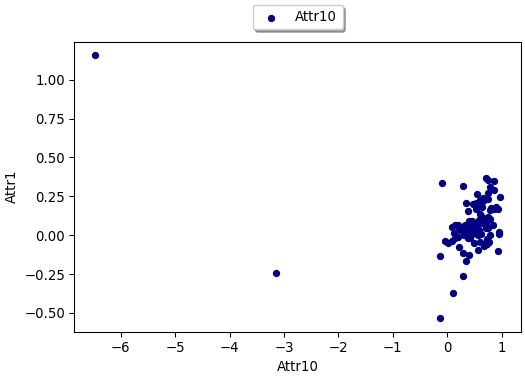

In [6]:
import pixiedust
display(df)

#  Custom Pipelines

In [6]:
def data_cleaning(df):
    # Drop columns with missing rate > n
    n = 0.3
    missing  = df.isna().sum().sort_values(ascending = False ) / df.shape[0] 
    imputable_columns = missing[missing < n].keys()
    df = df.loc[:,imputable_columns]
    
    return df
    
def data_preprocessing(df , holdoutratio = 0.02):
    # Create Train fold  and hide Test fold
    test_sample_class = int(df.shape[0] * holdoutratio)

    df_dropNA = df.dropna() #Drop Nan
    Test_Operating  = df_dropNA[df_dropNA['class'] == 0].sample(n=test_sample_class)
    Test_Default    = df_dropNA[df_dropNA['class'] == 1].sample(n=int(test_sample_class/2))


    Test = pd.concat([Test_Default,Test_Operating] , 0) # Create the Hide pure Test Data

    Train = df.loc[~df.index.isin(Test.index), :] # Remove the index of Test and create the Train Block from original df

    Test.sample(frac=1) # Shuffle randomly the Test Block

    return Train , Test

def balanced_sample_traning(df,target = 'class'):
    target = 'class'

    min_sample_size = df[target].value_counts().min()
    positive = df[df[target] == 1].sample(n = min_sample_size)
    negative = df[df[target] == 0].sample(n = min_sample_size)


    Train = pd.concat([positive,negative] , 0).sample(frac=1)

    return Train
    
def Model_Pipeline(df,target = 'class',n_iter = 50,scoring = 'f1',n_splits = 3):
    # Split Predictor and Response
    X  = df.drop('class',1)
    y  = df['class']
    #Initialize Functions for Pipeline
    Clf = XGBClassifier(objective  = 'binary:logistic')
    Kf  = StratifiedKFold(n_splits=n_splits,shuffle=True)
    Imp = KNNImputer()
    #Grid of possible combinations of parameters
    param_dist = {
                  # Imputation params
                  "Imputation__n_neighbors" : [1,3,5],
                  # CLF params
                  "Clf__scale_pos_weight "  : [1, 3, 100] ,
                  "Clf__learning_rate"      : [0.01, 0.1, 0.3] ,
                  "Clf__max_depth"          : [ 3, 5, 6],
                  'Clf__n_estimators'       : [300,800,1000],
                  "Clf__gamma"              : [ 0.0, 0.1, 0.2],
                  "Clf__colsample_bytree"   : [ 0.5,0.7,1 ] ,
                  "Clf__base_score"         : [0.45, 0.5 , 0.55]
    }
    # Pipeline Initialization
    pipeline = Pipeline([
                         ('Imputation',Imp),
                         ('Clf', Clf)
                        ])
    # Fit  model and validate model 
    GridS = RandomizedSearchCV(pipeline, 
                               param_distributions = param_dist,
                               cv = Kf,  
                               n_iter = n_iter,
                               scoring = scoring, 
                               error_score = 0, 
                               verbose = 0, 
                               n_jobs = -1)
    GridS.fit(X, y)
    return GridS , GridS.best_estimator_['Clf']
    

# Model Custom

In [7]:
import time
import warnings
warnings.filterwarnings('ignore')

t0 = time.time()
df = data_cleaning(df)
train , holdout = data_preprocessing(df)
train = balanced_sample_traning(train)
GridS , bestclf = Model_Pipeline(df = train)

t1 = time.time()

exec_time = t1 - t0

In [8]:
print('Exec_time: Minutes',exec_time/60)
results = pd.DataFrame(GridS.cv_results_).sort_values('rank_test_score',ascending = True)[['mean_test_score','std_test_score']]
results.head()

Exec_time: Minutes 1.9603791117668152


,mean_test_score,std_test_score
24,0.839024,0.017148
2,0.836193,0.003554
44,0.835942,0.018612
25,0.835597,0.010980
18,0.835350,0.012953


In [9]:
predictors = train.drop('class',1).columns
feature_importances = pd.Series(data  = GridS.best_estimator_['Clf'].feature_importances_ , index = predictors)
feature_importances.sort_values(ascending = False)[:10]

Attr39    0.187738
Attr16    0.039052
Attr38    0.034660
Attr46    0.028412
Attr43    0.027228
Attr64    0.026339
Attr26    0.026291
Attr27    0.024704
Attr32    0.024171
Attr55    0.023029
dtype: float32

In [10]:
GridS.best_estimator_['Clf']

XGBClassifier(base_score=0.45, gamma=0.2, learning_rate=0.3, max_depth=6,
              n_estimators=300, scale_pos_weight =3)

# Scoring Treeshold based on Risk appetite

In order to be more conservative or flexible we can use a different method for the final binary classification.
The final cut can be modified to be more towards a specific class.
If our personal judgment of the period suggest us to be more conservative, unless the confidence of the model is over a certain level we classify the company as risky or viceversa.
This simple trick allow the stakeholders to implement their judgment and risk appetite in the model.


In [11]:
# Unless the confidence of solid business is over 60, declare risk 
predictions  = (bestclf.predict_proba(holdout.drop('class',1).values)[:,1] >= 0.45).astype(int)
#predictions  = bestclf.predict(holdout.drop('class',1).values)

f1_score(holdout['class'] , predictions)

0.743801652892562

In [12]:
train['class'].value_counts()

1    351
0    351
Name: class, dtype: int64

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       118
           1       0.73      0.76      0.74        59

    accuracy                           0.82       177
   macro avg       0.80      0.81      0.81       177
weighted avg       0.83      0.82      0.83       177



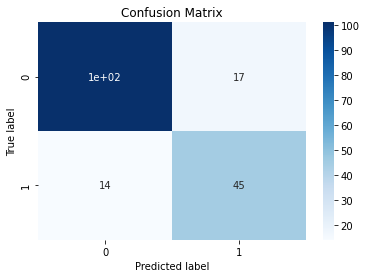

In [13]:
sns.heatmap(confusion_matrix( holdout['class'], predictions) , cmap  = 'Blues', annot = True )
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print(classification_report( holdout['class'], predictions))

# Deployment


##  Client 

In [13]:
from  ibm_watson_machine_learning import APIClient

# link for IBM location : https://cloud.ibm.com/apidocs/machine-learning

api_key = ""
location = "https://eu-de.ml.cloud.ibm.com"

wml_credentials = {
    
    "apikey": api_key,
    "url": location
}

client  = APIClient(wml_credentials)

## Store  model in Assets or Deployment Space

In [16]:
# Locate your Deployment Space 
WML_SPACE_ID = ""#'**inserire space ID**'
client.set.default_space(WML_SPACE_ID)


# Locate your Asset  -- Use this option to locate your model in the Asset section of project
#client.set.default_project(pc.projectID)

'SUCCESS'

In [15]:


pipeline = GridS.best_estimator_
X_train  = train.drop("class",1)
y_train  = train["class"]

model_name = "XGB_Bankruptcy_V1"
software_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")
scikit_version  = "scikit-learn_0.23"



meta_data = {
    
    client.repository.ModelMetaNames.NAME : model_name,
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID : software_spec_uid,
    client.repository.ModelMetaNames.TYPE: scikit_version 
}

stored_model_details = client.repository.store_model(model = pipeline,
                                                    meta_props=meta_data,
                                                    training_data=X_train,
                                                    training_target=y_train)

In [16]:
model_uid = client.repository.get_model_uid(stored_model_details)
print("Model uid: {}".format(model_uid))


Model uid: 5efa6619-17b7-47a0-8a16-67b62685e3a0


## Promotion of model to Deployment Space

In [17]:

# Use this cell to do any cleanup of previously created models and deployments
client.repository.list_models()

#client.repository.delete()#'GUID of stored model'
#client.deployments.delete()#'GUID of deployed model'

------------------------------------  -----------------  ------------------------  -----------------
ID                                    NAME               CREATED                   TYPE
5efa6619-17b7-47a0-8a16-67b62685e3a0  XGB_Bankruptcy_V1  2021-03-01T13:18:42.002Z  scikit-learn_0.23
------------------------------------  -----------------  ------------------------  -----------------


##  Deployment Online

In [18]:
DEPLOYMENT_NAME = "XGB_Bankruptcy_V1"

print("Deploying model...")
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}


deployment = client.deployments.create(model_uid, meta_props=metadata)

#Save the Deployment id
deployment_uid = client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '5efa6619-17b7-47a0-8a16-67b62685e3a0' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='3bfd2566-d691-4937-b0d5-f737aa5405d3'
------------------------------------------------------------------------------------------------


Model id: 5efa6619-17b7-47a0-8a16-67b62685e3a0
Deployment id: 3bfd2566-d691-4937-b0d5-f737aa5405d3


new_company = holdout.sample(1)
real_condition = new_company['class']
inputs = new_company.drop('class',1)


fields = inputs.columns.tolist()
values = inputs.values.tolist()
{"input_data": [{"fields": fields, "values": values}]}

## Call Model via API 

In [54]:
from matplotlib import cm

def prediction_custom(predictions):

    centre_circle = plt.Circle((0,0),0.70,fc='snow')
    fig = plt.gcf()

    fig.gca().add_artist(centre_circle)

    plt.title('Model Response:',fontsize = 24)

    cs=cm.Blues(np.arange(2)/2)
    pd.Series(predictions['predictions'][0]['values'][0][1] ,
              index=['%Solid','%Risky']).plot(kind  = 'pie',startangle=0,fontsize = 12,
                                                    pctdistance=0.8,autopct='%1.1f%%',
                                                    colors=cs,figsize = (20,6),
                                                    explode = tuple([0.02 for i in range(0,2)]))
    plt.ylabel('_');
    #ax1.axis('equal')  
    plt.tight_layout()

    label = plt.annotate(str(predictions['predictions'][0]['values'][0][0]),
                         xy=(0, 0), 
                         fontsize=80,
                         verticalalignment='center',
                         horizontalalignment='center',)
    plt.show()

In [51]:
# Locate your Deployment Space 
WML_SPACE_ID = ""#'**inserire space ID**'
client.set.default_space(WML_SPACE_ID)

# Locate your Asset  -- Use this option to locate your model in the Asset section of project
#client.set.default_project(pc.projectID)
new_company = holdout.sample(1)
real_condition = new_company['class']
inputs = new_company.drop('class',1)


fields = inputs.columns.tolist()
values = inputs.values.tolist()

deployment_uid = ''
scoring_payload = {"input_data": [{"fields": fields, "values": values}]}
predictions = client.deployments.score(deployment_uid, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [[1, [0.2671446204185486, 0.7328553795814514]]]}]}

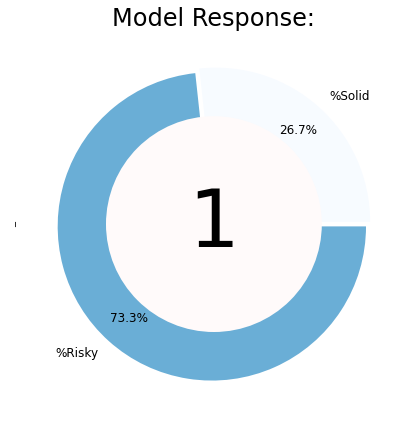

In [55]:
prediction_custom(predictions=predictions)